<a href="https://colab.research.google.com/github/ViniciusBerti/20241_maua_ecm252_intro_git/blob/main/C%C3%B3pia_de_IMT_Exemplo_ARIMA_1_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **$ARIMA(p,d,q)$**



# **CASE:** Vendas diárias e projeção mensal

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.datasets import co2
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


# **Exercício 1**

In [ ]:
#@markdown Just run
path = 'https://github.com/Rogerio-mack/IMT_CD_2025/raw/refs/heads/main/data/'

df = pd.read_csv(path + 'vendas_319326781.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df = df.dropna()
df.columns = ['ts']


# **CASE**: Vendas diárias e mensais

Dada a série de vendas diárias abaixo faça um modelo $ARIMA(p,d,q)$ para previsão da média de vendas no mês.

1. Determine os parâmetros do modelo $ARIMA(p,d,q)$
2. Determine o erro de predição das vendas de 2025
3. Verifique o melhor modelo $ARIMA(p,d,q)$ pelo critério AIC e erro RMSE


,ts
2020-01-12,2525.616228
2020-01-13,2722.941475
2020-01-14,2720.712373
2020-01-15,2730.318188
2020-01-16,2602.740529


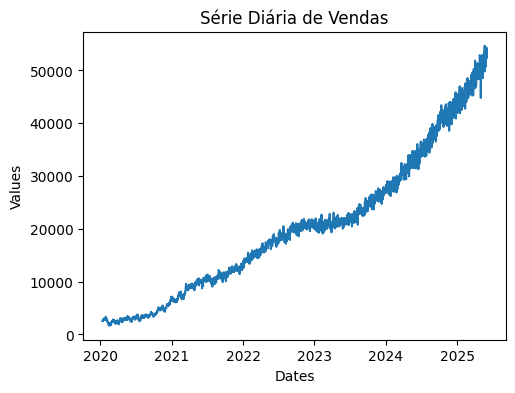

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(df)
plt.title('Série Diária de Vendas')
plt.xlabel('Dates')
plt.ylabel('Values')

df.head()

# 1. (\*) Data, Pré-Processamento

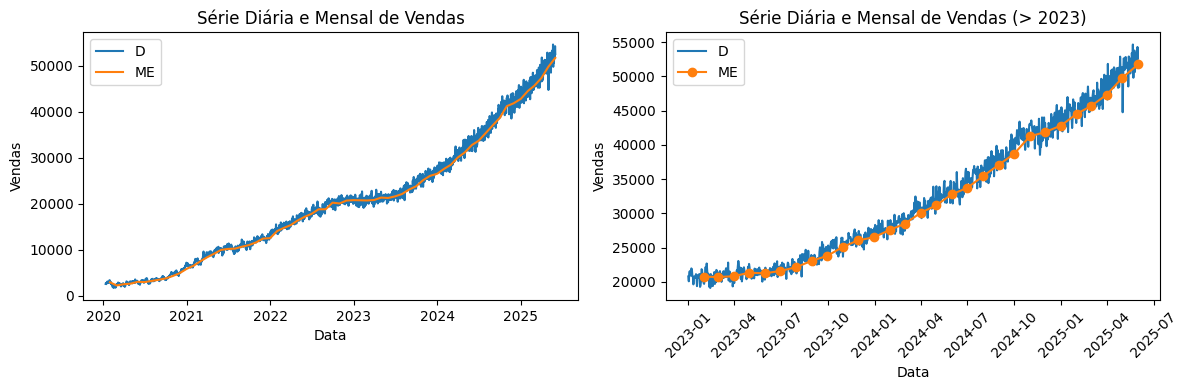

Dados diários: 1967 observações
Dados mensais: 65 observações


In [ ]:
data_monthly = df.resample('ME').mean()
data_monthly = data_monthly.fillna(data_monthly.bfill())
ts = data_monthly['ts']

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(df, label='D')
plt.plot(ts, label='ME')
plt.title('Série Diária e Mensal de Vendas')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df[df.index >= pd.to_datetime('2023-01-01')], label='D')
plt.plot(ts[ts.index >= pd.to_datetime('2023-01-01')], label='ME', marker='o')
plt.title('Série Diária e Mensal de Vendas (> 2023)')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"Dados diários: {len(df)} observações")
print(f"Dados mensais: {len(ts)} observações")

# 2. Exploração da Série, Decomposição

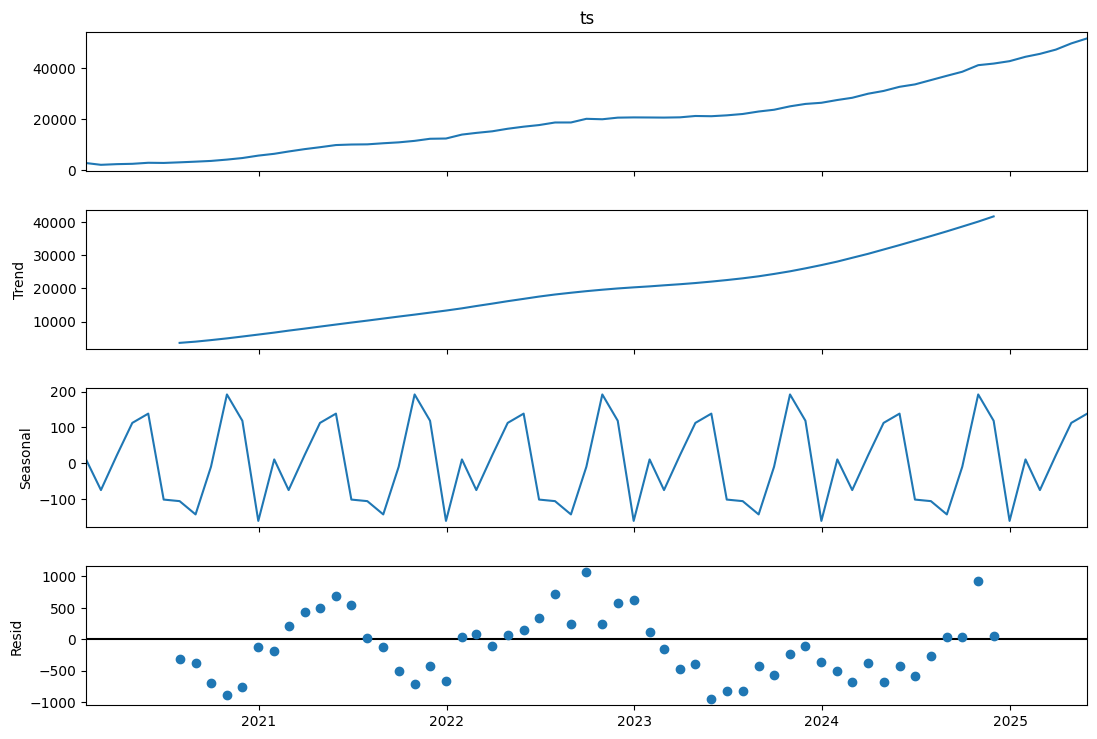

In [ ]:
decomposition = seasonal_decompose(ts, model='additive')

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

# 3. (\*) Teste de estacionariedade (Dickey-Fuller Aumentado - ADF), **$d$**

Uma série estacionária, é uma série em que as estatísticas dos dados, isto é, média, variância e covariância não mudam ao longo do tempo.

> Dickey-Fuller Aumentado - ADF, $H_0 =$ *Série não é estacionária*

In [ ]:
def adf_test(series):
    result = adfuller(series)
    print('Teste ADF:')
    print(f'Estatística ADF: {result[0]:.4f}')
    print(f'Valor-p: {result[1]:.4f}')
    print('Valores Críticos:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    if result[1] <= 0.05:
        print('A série temporal é estacionária (rejeita H0)')
    else:
        print('A série temporal não é estacionária (falha em rejeitar H0)')
    return result[1]

print("=== Teste ADF na série original ===")
adf_result = adf_test(ts)

d = 0
ts_diff = ts.copy()

while adf_result > 0.05:
    d += 1
    ts_diff = ts_diff.diff().dropna()
    print(f"\n=== Teste ADF após diferenciação (d={d}) ===")
    adf_result = adf_test(ts_diff)

print(f"\nParâmetro d determinado: {d}")

=== Teste ADF na série original ===
Teste ADF:
Estatística ADF: 1.8549
Valor-p: 0.9985
Valores Críticos:
	1%: -3.5424
	5%: -2.9102
	10%: -2.5927
A série temporal não é estacionária (falha em rejeitar H0)

=== Teste ADF após diferenciação (d=1) ===
Teste ADF:
Estatística ADF: -0.8449
Valor-p: 0.8056
Valores Críticos:
	1%: -3.5424
	5%: -2.9102
	10%: -2.5927
A série temporal não é estacionária (falha em rejeitar H0)

=== Teste ADF após diferenciação (d=2) ===
Teste ADF:
Estatística ADF: -9.6116
Valor-p: 0.0000
Valores Críticos:
	1%: -3.5424
	5%: -2.9102
	10%: -2.5927
A série temporal é estacionária (rejeita H0)

Parâmetro d determinado: 2


# 4. (\*) Auto-correlação e Correlação Parcial, ACF e PACF, **$q, p$**

* PACF (Partial Autocorrelation Function) → usado para escolher $p$ (parte autoregressiva AR)

* ACF (Autocorrelation Function) → usado para escolher $q$ (parte média móvel MA)

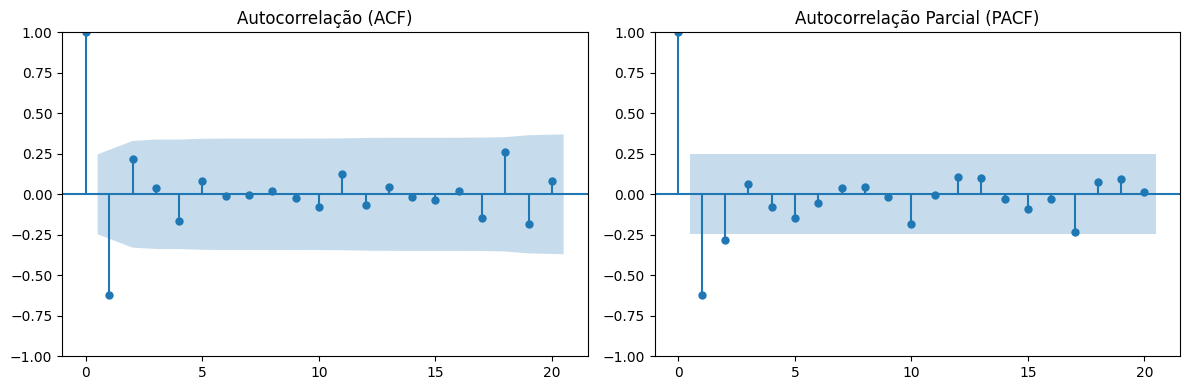

Observações para determinar p e q:
- PACF: Observar onde os lags se tornam não significativos para determinar p
- ACF: Observar onde os lags se tornam não significativos para determinar q


In [ ]:
max_lags = min(20, len(ts_diff) // 2 - 1)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(ts_diff, lags=max_lags, ax=ax1)
ax1.set_title('Autocorrelação (ACF)')

plot_pacf(ts_diff, lags=max_lags, ax=ax2)
ax2.set_title('Autocorrelação Parcial (PACF)')

plt.tight_layout()
plt.show()

print("Observações para determinar p e q:")
print("- PACF: Observar onde os lags se tornam não significativos para determinar p")
print("- ACF: Observar onde os lags se tornam não significativos para determinar q")

# Q, P = 1, 2

# 5. (\*) Forecast,

$$ARIMA(p, d, q)(0,0,0,0)$$



Dados de treino: 52 observações
Dados de teste: 13 observações

=== Resumo do Modelo ARIMA ===
                               SARIMAX Results                                
Dep. Variable:                     ts   No. Observations:                   52
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -368.621
Date:                Thu, 29 May 2025   AIC                            745.241
Time:                        23:22:40   BIC                            752.889
Sample:                    01-31-2020   HQIC                           748.154
                         - 04-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0886      0.713     -1.526      0.127      -2.487       0.310
ar.L2         -0.3883      0.507    

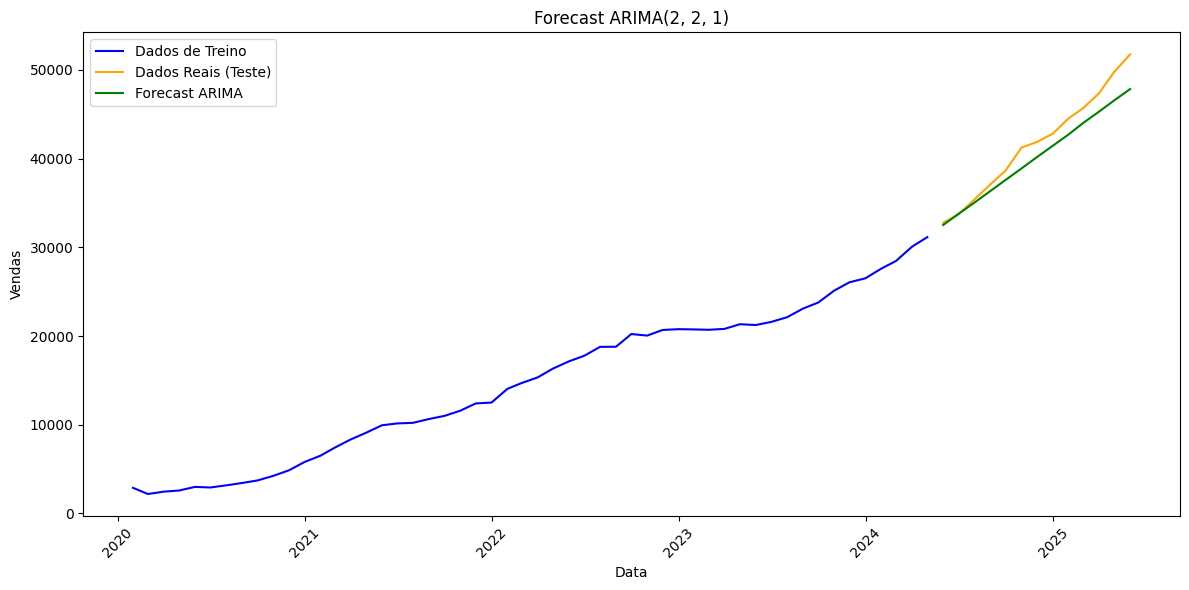

In [ ]:
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

print(f"Dados de treino: {len(train)} observações")
print(f"Dados de teste: {len(test)} observações")

order = (2, 2, 1)  # (p, d, q)

model = ARIMA(train, order=order)
model_fit = model.fit()

print("\n=== Resumo do Modelo ARIMA ===")
print(model_fit.summary())

forecast_steps = len(test)
forecast = model_fit.predict(start=test.index[0], end=test.index[-1])

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Dados de Treino', color='blue')
plt.plot(test.index, test, label='Dados Reais (Teste)', color='orange')
plt.plot(test.index, forecast, label='Forecast ARIMA', color='green')
plt.title(f'Forecast ARIMA{order}')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Análise dos Resíduos

## Testes de normalidade do erro

RMSE do conjunto de teste: 1888.17


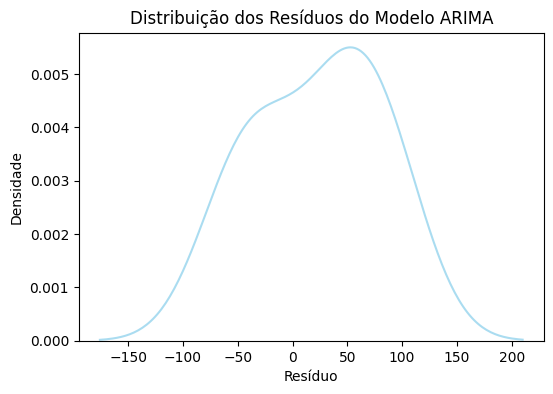

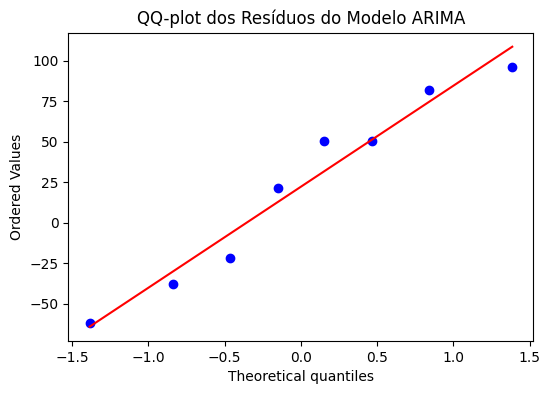

Teste de Jarque-Bera para Normalidade dos Resíduos:
Estatística de teste: 0.9967
Valor-p: 0.6075
Os resíduos parecem ser normalmente distribuídos (não rejeitar H0)


In [ ]:
residuals = model_fit.resid

rmse = np.sqrt(np.mean((test - forecast) ** 2))
print(f'RMSE do conjunto de teste: {rmse:.2f}')

plt.figure(figsize=(6, 4))
sns.kdeplot(residuals[ np.abs(residuals) < 100 ], alpha=0.7, color='skyblue')
plt.title('Distribuição dos Resíduos do Modelo ARIMA')
plt.xlabel('Resíduo')
plt.ylabel('Densidade')

plt.show()

from matplotlib import pyplot
plt.figure(figsize=(6,4))
import scipy.stats as stats
stats.probplot(residuals[ np.abs(residuals) < 100 ], dist="norm", plot=plt)
plt.title('QQ-plot dos Resíduos do Modelo ARIMA')
pyplot.show()

from scipy.stats import jarque_bera

jb_stat, jb_pvalue = jarque_bera(residuals[2:-2])

print(f'Teste de Jarque-Bera para Normalidade dos Resíduos:')
print(f'Estatística de teste: {jb_stat:.4f}')
print(f'Valor-p: {jb_pvalue:.4f}')
if jb_pvalue > 0.05:
    print('Os resíduos parecem ser normalmente distribuídos (não rejeitar H0)')
else:
    print('Os resíduos não parecem ser normalmente distribuídos (rejeita H0)')

## Correlação dos resíduos

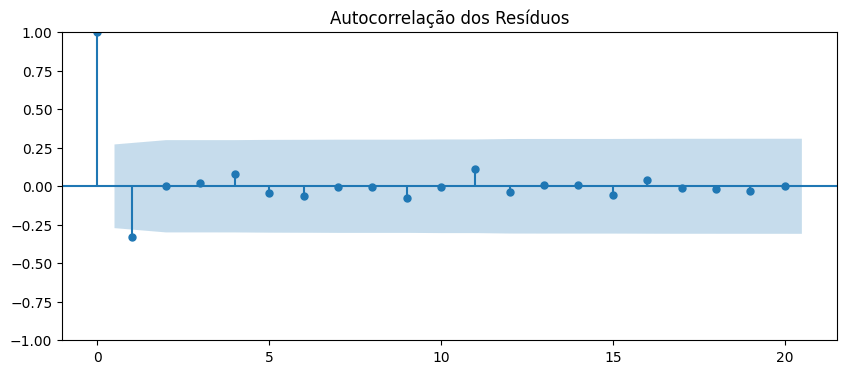

Idealmente, os resíduos não devem apresentar autocorrelação significativa.
Se houver autocorrelação, pode indicar que o modelo pode ser melhorado.


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plot_acf(residuals, lags=20, ax=ax)
ax.set_title('Autocorrelação dos Resíduos')
plt.show()

print("Idealmente, os resíduos não devem apresentar autocorrelação significativa.")
print("Se houver autocorrelação, pode indicar que o modelo pode ser melhorado.")

# 7. (\*) Análise do Erro

In [ ]:
rmse = np.sqrt(np.mean((test - forecast) ** 2))
mae = np.mean(np.abs(test - forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f'=== Métricas de Erro do Modelo ARIMA{order} ===')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

print(f'\n=== Estatísticas dos Resíduos ===')
print(f'Média: {residuals.mean():.4f}')
print(f'Desvio Padrão: {residuals.std():.4f}')
print(f'Min: {residuals.min():.4f}')
print(f'Max: {residuals.max():.4f}')

=== Métricas de Erro do Modelo ARIMA(2, 2, 2) ===
RMSE: 1888.17
MAE: 1550.65
MAPE: 3.45%

=== Estatísticas dos Resíduos ===
Média: 75.7009
Desvio Padrão: 621.1287
Min: -2060.7019
Max: 2891.1087


# 8. (\*) Seleção de Modelos para vários parâmetros

In [ ]:
from itertools import product

p_values = range(0, 4)
d_values = [d]
q_values = range(0, 4)

results = []

print("Testando diferentes combinações de parâmetros ARIMA...")
print("(p, d, q) | AIC | RMSE")
print("-" * 25)

for p, d_val, q in product(p_values, d_values, q_values):
    if p == 0 and q == 0:
        continue

    try:
        model_temp = ARIMA(train, order=(p, d_val, q))
        model_fit_temp = model_temp.fit()

        forecast_temp = model_fit_temp.predict(start=test.index[0], end=test.index[-1])

        aic = model_fit_temp.aic
        rmse_temp = np.sqrt(np.mean((test - forecast_temp) ** 2))

        results.append({
            'order': (p, d_val, q),
            'AIC': aic,
            'RMSE': rmse_temp,
            'model': model_fit_temp
        })

        print(f"({p}, {d_val}, {q}) | {aic:.2f} | {rmse_temp:.2f}")

    except Exception as e:
        print(f"({p}, {d_val}, {q}) | Erro: {str(e)[:30]}...")
        continue

best_aic = min(results, key=lambda x: x['AIC'])
best_rmse = min(results, key=lambda x: x['RMSE'])

print(f"\n=== Melhores Modelos ===")
print(f"Melhor AIC: ARIMA{best_aic['order']} | AIC: {best_aic['AIC']:.2f} | RMSE: {best_aic['RMSE']:.2f}")
print(f"Melhor RMSE: ARIMA{best_rmse['order']} | AIC: {best_rmse['AIC']:.2f} | RMSE: {best_rmse['RMSE']:.2f}")

Testando diferentes combinações de parâmetros ARIMA...
(p, d, q) | AIC | RMSE
-------------------------
(0, 2, 1) | 750.98 | 3371.39
(0, 2, 2) | 744.94 | 1247.43
(0, 2, 3) | 745.49 | 1944.96
(1, 2, 0) | 744.21 | 1790.41
(1, 2, 1) | 743.98 | 2082.88
(1, 2, 2) | 745.37 | 1622.48
(1, 2, 3) | 747.33 | 1756.62
(2, 2, 0) | 743.41 | 1983.71
(2, 2, 1) | 745.24 | 1925.49
(2, 2, 2) | 747.22 | 1888.17
(2, 2, 3) | 749.22 | 1905.19
(3, 2, 0) | 745.23 | 1863.15
(3, 2, 1) | 747.23 | 1856.34


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 2) | 747.17 | 2321.21
(3, 2, 3) | 750.62 | 3573.32

=== Melhores Modelos ===
Melhor AIC: ARIMA(2, 2, 0) | AIC: 743.41 | RMSE: 1983.71
Melhor RMSE: ARIMA(0, 2, 2) | AIC: 744.94 | RMSE: 1247.43


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Modelo Final Selecionado: ARIMA(0, 2, 2) ===


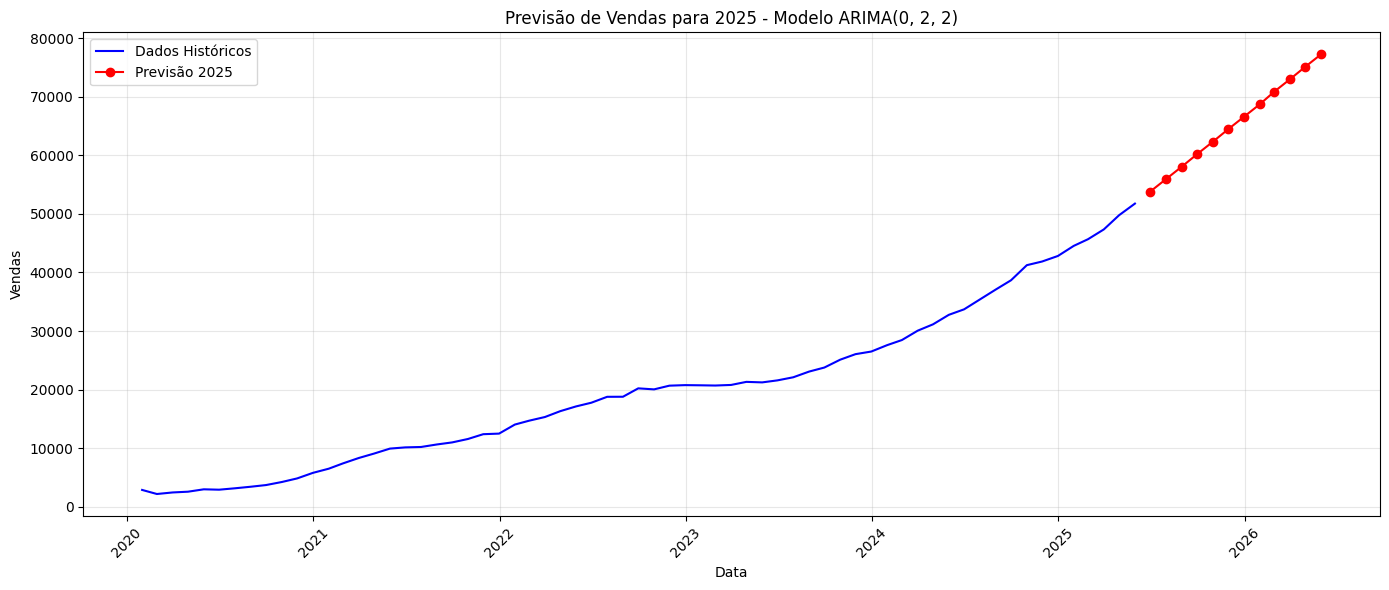


=== Previsões de Vendas Mensais para 2025 ===
2025-06: 53813.68
2025-07: 55943.13
2025-08: 58072.59
2025-09: 60202.04
2025-10: 62331.49
2025-11: 64460.94
2025-12: 66590.39
2026-01: 68719.84
2026-02: 70849.30
2026-03: 72978.75
2026-04: 75108.20
2026-05: 77237.65

Média de vendas prevista para 2025: 65525.67
Total de vendas previsto para 2025: 786308.00


In [ ]:
best_model = best_rmse['model']
best_order = best_rmse['order']

print(f"\n=== Modelo Final Selecionado: ARIMA{best_order} ===")

final_model = ARIMA(ts, order=best_order)
final_model_fit = final_model.fit()

forecast_2025 = final_model_fit.forecast(steps=12)
forecast_index = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=12, freq='ME')

plt.figure(figsize=(14, 6))
plt.plot(ts.index, ts, label='Dados Históricos', color='blue')
plt.plot(forecast_index, forecast_2025, label='Previsão 2025', color='red', marker='o')
plt.title(f'Previsão de Vendas para 2025 - Modelo ARIMA{best_order}')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n=== Previsões de Vendas Mensais para 2025 ===")
for i, (date, value) in enumerate(zip(forecast_index, forecast_2025)):
    print(f"{date.strftime('%Y-%m')}: {value:.2f}")

print(f"\nMédia de vendas prevista para 2025: {forecast_2025.mean():.2f}")
print(f"Total de vendas previsto para 2025: {forecast_2025.sum():.2f}")

# **Exercício 2**

Aplique o teste de significância adequado que demonstra se há diferença significativa entre as médias anuais e as séries de diferenças ($d=0,1,2$), exibindo um tabela como abaixo.

TypeError: Data source must be a DataFrame or Mapping, not <class 'pandas.core.series.Series'>.

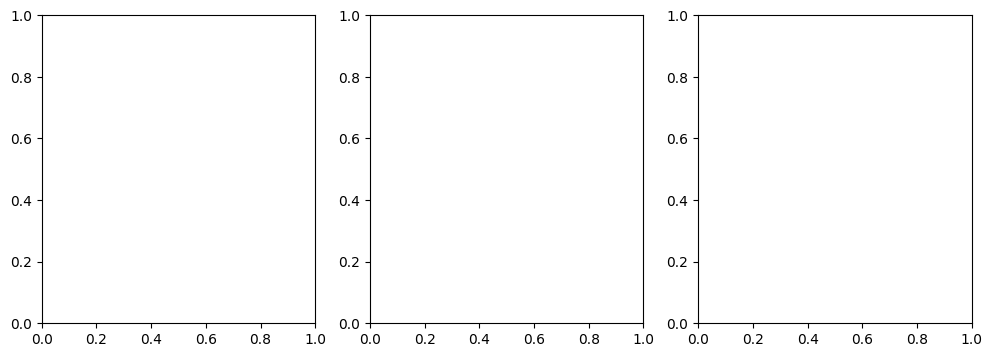

In [ ]:
#@markdown Just run
fig, ax = plt.subplots(1,3,figsize=(12, 4))

for label, ts_ in zip(np.arange(3),[ts, ts.diff().dropna(), ts.diff().diff().dropna(),]):

  ts_with_year = ts_.copy() # .to_frame(name='ts') # .diff().diff().dropna().to_frame(name='ts')
  ts_with_year['year'] = ts_with_year.index.year

  sns.boxplot(x='year', y='ts', data=ts_with_year,ax=ax[label])
  ax[label].set_title(f'Médias de ts por ano, diff = {label}')

plt.tight_layout()
plt.show()


In [ ]:
from scipy import stats

ts_original = ts
ts_diff1 = ts.diff().dropna()
ts_diff2 = ts.diff().diff().dropna()

def test_annual_means_significance(time_series, diff_level):
    ts_df = time_series.to_frame(name='ts')
    ts_df['year'] = ts_df.index.year

    annual_groups = [group['ts'].values for name, group in ts_df.groupby('year')]

    annual_groups = [group for group in annual_groups if len(group) >= 2]

    if len(annual_groups) < 2:
        return None, None, None

    f_stat, p_value = stats.f_oneway(*annual_groups)

    return f_stat, p_value, len(annual_groups)

results = []

for diff_level, ts_data in enumerate([ts_original, ts_diff1, ts_diff2]):
    f_stat, p_value, n_groups = test_annual_means_significance(ts_data, diff_level)

    if f_stat is not None:
        significant = "Sim" if p_value < 0.05 else "Não"

        results.append({
            'Diferenciação (d)': diff_level,
            'F-estatística': round(f_stat, 4),
            'p-valor': round(p_value, 4),
            'Significativo (α=0.05)': significant,
            'Grupos (anos)': n_groups
        })
    else:
        results.append({
            'Diferenciação (d)': diff_level,
            'F-estatística': 'N/A',
            'p-valor': 'N/A',
            'Significativo (α=0.05)': 'N/A',
            'Grupos (anos)': 'Dados insuficientes'
        })

results_df = pd.DataFrame(results)
print("\nTeste de Significância das Médias Anuais por Nível de Diferenciação")
print("=" * 80)
print(results_df.to_string(index=False))

print("\n\nInterpretação dos Resultados:")
print("-" * 40)
for i, result in enumerate(results):
    if result['p-valor'] != 'N/A':
        if result['Significativo (α=0.05)'] == "Sim":
            print(f"d={i}: Há diferença significativa entre as médias anuais (p={result['p-valor']})")
        else:
            print(f"d={i}: Não há diferença significativa entre as médias anuais (p={result['p-valor']})")
    else:
        print(f"d={i}: {result['Grupos (anos)']}")

results_df = pd.DataFrame(results)
results_df


Teste de Significância das Médias Anuais por Nível de Diferenciação
 Diferenciação (d)  F-estatística  p-valor Significativo (α=0.05)  Grupos (anos)
                 0       261.7678   0.0000                    Sim              6
                 1        13.1209   0.0000                    Sim              6
                 2         0.2248   0.9503                    Não              6


Interpretação dos Resultados:
----------------------------------------
d=0: Há diferença significativa entre as médias anuais (p=0.0)
d=1: Há diferença significativa entre as médias anuais (p=0.0)
d=2: Não há diferença significativa entre as médias anuais (p=0.9503)


,Diferenciação (d),F-estatística,p-valor,Significativo (α=0.05),Grupos (anos)
0,0,261.7678,0.0000,Sim,6
1,1,13.1209,0.0000,Sim,6
2,2,0.2248,0.9503,Não,6


Fake results...


,ts Diff,f_statistic,p_value,Rejeita H0
0,d=0,266.4655,0.0100,True
1,d=1,18.5178,0.0600,False
2,d=2,0.4088,0.2016,False
